In [1]:
import datetime
from datetime import timezone
import pytz

from util import *

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
coin_list = cg.get_coins_list()

id_to_data = {}
for coin_data in coin_list:
    id_to_data[coin_data.pop('id')] = coin_data
ids = id_to_data.keys()


In [4]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)
# df_market

In [5]:
##################
## LOCAL DRIVER ##
##################

nat_tz = 'America/Los_Angeles'
nat_tzobj = pytz.timezone(nat_tz)

trg_tzobj = timezone.utc



start_date, end_date = (2018,9,1), (2020,9,1)

port_ids = ['bitcoin', 'dogecoin', 'ethereum', 'bolt']


NAT_CURR = 'usd'

ROLL_WIND = 14
LOOKBACKS = [7, 14, 30]


## Create portfolio dataframe
port_df = create_portfolio_from_ids(cg, port_ids, start_date, end_date)


<Figure size 432x288 with 0 Axes>

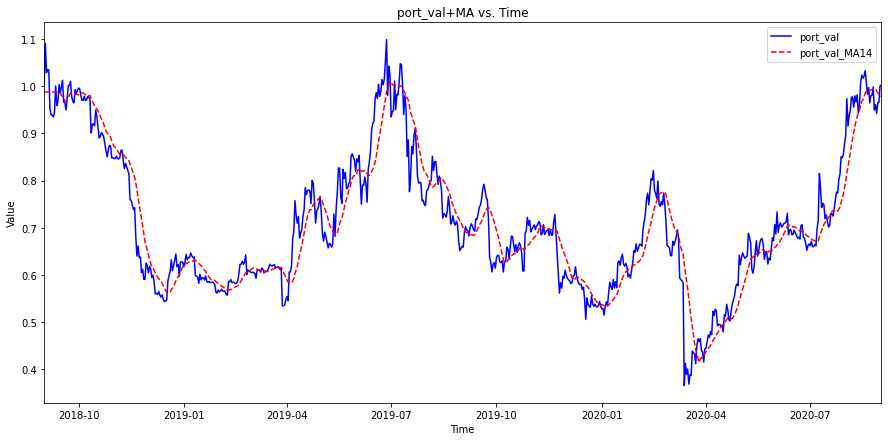

p-value = 0.0 The series port_val_RM_I is likely stationary.
(-27.33935147390005, 0.0, array([-3.91148482, -3.34450132, -3.05025701]))


In [6]:
############
## TEST 1 ##
############

## Create normalized timeseries for portfolio
port_val = port_df['port_val']
port_rm = take_roll_avg(port_val, ROLL_WIND)
port_rm.name = f'{port_val.name}_RM'


### IF a random variable is stationary THEN it is also order one integratable ###
# if test_stationarity(port_rm):

port_ret = integrate(port_rm)


comparator = port_ret + np.random.normal(0, 5, len(port_ret))

# These two series should be stationary and cointegrate
coint_res = is_coint(port_ret, comparator)
print(coint_res)

In [7]:
############
## TEST 2 ##
############

col_1, col_2 = port_df.columns[:2]
s_1, s_2 = port_df[col_1], port_df[col_2]

# Random two series likely should not be stationary
coint_res = is_coint(s_1, s_2)
print(coint_res)

p-value = 0.024423564986527865 The series None is likely non-stationary.
False


<Figure size 432x288 with 0 Axes>

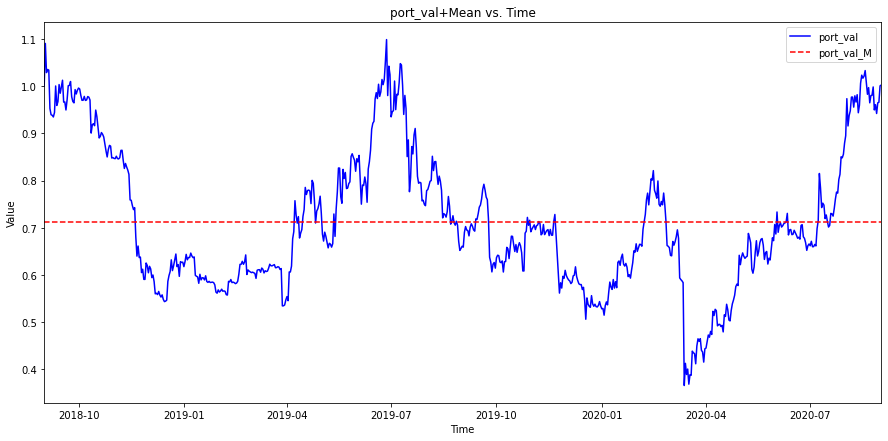

<Figure size 432x288 with 0 Axes>

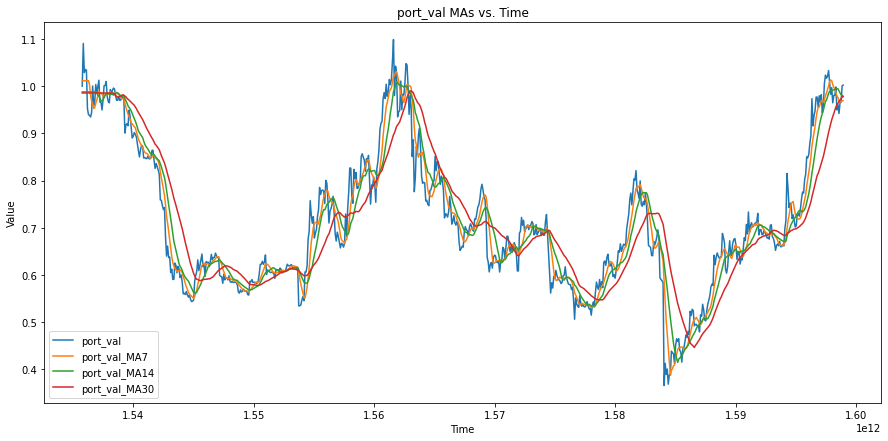

0.3042805366931269


In [8]:
take_mean(port_val)
df_feats = series_to_df_feats(port_val, LOOKBACKS, plot=True)

print(sharpe_ratio(df_feats['port_val_DR']))
